In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import xarray as xr
import matplotlib.pyplot as plt
import dask
import xesmf as xe
import proplot as pplt
import cartopy.feature as cfeature
import xskillscore as xs

import warnings
warnings.filterwarnings("ignore")

In [2]:
def rednoise(ds,h):
    
    
    lags=[1,2]
    red_list=[]
    for v in list(ds.keys()):
        x=ds[v]
        corr_list=[]
        for l in lags:
            _,cor,_,_,_,_=lag_linregress_3D(x, x, lagx=0, lagy=l)
            corr_list.append(cor.values)
  

        rho=0.5*(corr_list[0]+np.sqrt(corr_list[1]))
        print(v,rho)
        numerator=1-rho**2
        denomenator=1-(2*rho*np.cos(h*np.pi/np.max(h)))+rho**2
        red=numerator/denomenator
        red_list.append(red)
    
    return red_list

In [3]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

In [4]:
def powerSpectra(ds_ts,w):
    
    P_list=[]
    for v in list(ds_ts.keys()):
        
        x=ds_ts[v].values
        x = x[~np.isnan(x)]
        f, P = signal.welch(x,detrend=False,nperseg=w,scaling='spectrum')
        ds_P=xr.DataArray(P,coords={'freq':f},dims=['freq']).to_dataset(name=v)

        P_list.append(ds_P)
        
    ds=xr.merge(P_list)
    return ds

In [5]:
def getTS(ds_anoms,ds_comp,seas,file=''):
    
    nt=len(ds_anoms['time'])
    nx=len(ds_anoms['lon'])
    ny=len(ds_anoms['lat'])
    
    ds_anoms=ds_anoms.fillna(0.0)
    ds_comp=ds_comp.fillna(0.0)
    
    var_list=[]         
    for v in list(ds_anoms.keys()):
                 
        anoms=ds_anoms[v].values.reshape(nt,nx*ny)
        comp=ds_comp[v].sel(seas=seas).values.reshape(nx*ny)
        
        ts=np.matmul(anoms,comp)
    
        ds_ts=xr.DataArray(ts,coords={'time':ds_anoms['time']},
                           dims=['time']).to_dataset(name=v)

        var_list.append(ds_ts)
                 
    ds_var=xr.merge(var_list)
                     
    return ds_var

In [6]:
def plotCompLRPCirc(ds_tmp,ds_comp,file=''):

    lon_0=290
    levs_z500=np.arange(-700,700,100)
    levs_z850=np.arange(-400,450,100)
    levs_u200=np.arange(-10,12,2)
    levs_u850=np.arange(-10,12,2)
    levs_lrp=np.arange(0.5,3,0.25)
    
    f, axs = pplt.subplots(ncols=2, nrows=2,
                           proj=['npstere','npstere','npstere','npstere'],
                           proj_kw={'lon_0': lon_0},width=8.5,height=11.0)

    for i,seas in enumerate(['DJF','JJA']):
    

        #Z500 with LRP
        m=axs[i,0].pcolormesh(ds_tmp['lon'],ds_tmp['lat'],
              ds_tmp.sel(seas=seas,var='z500'),cmap='grays',extend='both',levels=levs_lrp)
        axs[i,0].format(coast=True,grid=True,title=seas+' Z500',abc=True)
        axs[i,0].quiver(ds_comp['lon'],ds_comp['lat'],
                ds_comp['u200'].sel(seas=seas).values,ds_comp['v200'].sel(seas=seas).values,color='g')
        axs[i,0].contour(ds_comp['lon'],ds_comp['lat'],ds_comp['z500'].sel(seas=seas),levels=levs_z500,cmap='BR')

        #Z850 with LRP
        m=axs[i,1].pcolormesh(ds_tmp['lon'],ds_tmp['lat'],
              ds_tmp.sel(seas=seas,var='z850'),cmap='grays',extend='both',levels=levs_lrp)
        axs[i,1].format(coast=True,grid=True,title=seas+' Z850',abc=True)
        axs[i,1].quiver(ds_comp['lon'],ds_comp['lat'],
                ds_comp['u850'].sel(seas=seas).values,ds_comp['v850'].sel(seas=seas).values,color='g')
        axs[i,1].contour(ds_comp['lon'],ds_comp['lat'],ds_comp['z850'].sel(seas=seas),levels=levs_z850,cmap='BR')


    f.colorbar(m,loc='b',length=0.7)
    

In [7]:
def plotCompLRPGlobe(ds_tmp,ds_comp,file=''):

    lon_0=290
    levs_sst=np.arange(-1,1.1,0.1)
    levs_olr=np.arange(-14,15,2)
    levs_lrp=np.arange(0.5,3,0.25)
    
    f, axs = pplt.subplots(ncols=2, nrows=2,
                           proj=['robin','robin','robin','robin'],
                           proj_kw={'lon_0': lon_0},width=11.0,height=8.5)

    for i,seas in enumerate(['DJF','JJA']):


        # SST
        m=axs[i,0].pcolormesh(ds_tmp['lon'],ds_tmp['lat'],
              ds_tmp.sel(seas=seas,var='sst'),cmap='grays',extend='both',levels=levs_lrp)
        axs[i,0].format(land=True,landcolor='black',grid=True,title=seas+' SST',abc=True)
        axs[i,0].contour(ds_comp['lon'],ds_comp['lat'],ds_comp['sst'].sel(seas=seas),levels=levs_sst,cmap='BR')

        #OLR
        m=axs[i,1].pcolormesh(ds_tmp['lon'],ds_tmp['lat'],
              ds_tmp.sel(seas=seas,var='olr'),cmap='grays',extend='both',levels=levs_lrp)
        axs[i,1].format(coast=True,grid=True,title=seas+' OLR',abc=True)
        axs[i,1].contour(ds_comp['lon'],ds_comp['lat'],ds_comp['olr'].sel(seas=seas),levels=levs_olr,cmap='BR')

    f.colorbar(m,loc='b',length=0.7)

In [8]:
def getGoodFcsts(ds_model,model_type,fcst_category,thresh=0.8):
    fcsts=ds_model.where(np.logical_and(ds_model['pred']==ds_model['verif'],
                                        ds_model['probs'].sel(cat=fcst_category)>=confidence_thresh)).sel(model_type=model_type)
    count_str=str(int(np.count_nonzero(~np.isnan(fcsts['probs'].sel(cat='Upper')))))

    return fcsts,count_str

In [9]:
def getFields():
    tfiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.sea.surface.temperature.0.75.x.0.75.1979-2018.nc'
    zfiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.geoheight.*.nc'
    ufiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.u.*.nc'
    vfiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.v.*.nc'

    # Z500 and Z850
    ds_z=xr.open_mfdataset(zfiles,combine='by_coords')
    ds_z500=ds_z.sel(level=500).rename({'z':'z500'})
    ds_z850=ds_z.sel(level=850).rename({'z':'z850'})

    # U200 and U850
    ds_u=xr.open_mfdataset(ufiles,combine='by_coords')
    ds_u200=ds_u.sel(level=200).rename({'u':'u200'})
    ds_u850=ds_u.sel(level=850).rename({'u':'u850'})
    
    # V200 and V850
    ds_v=xr.open_mfdataset(vfiles,combine='by_coords')
    ds_v200=ds_v.sel(level=200).rename({'v':'v200'})
    ds_v850=ds_v.sel(level=850).rename({'v':'v850'})

    # SST
    ds_sst=xr.open_mfdataset(tfiles,combine='by_coords')
    ds_sst=ds_sst.sel(time=ds_sst['time.hour']==0)

    # OLR
    olrfiles1='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.top.net.thermal.radiation.19*s.nc'
    olrfiles2='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.top.net.thermal.radiation.20*s.nc'
    ds_olr1=xr.open_mfdataset(olrfiles1,combine='by_coords',combine_attrs='drop_conflicts')
    ds_olr1['time']=ds_olr1['time'].dt.floor('d')
    ds_olr2=xr.open_mfdataset(olrfiles2,combine='by_coords')
    ds_olr=xr.combine_by_coords([ds_olr1,ds_olr2],combine_attrs='drop_conflicts').rename({'ttr':'olr'})
    ds_olr['olr']=ds_olr['olr']*-1
    
    
    # Coarse Grain Data
    new_lon=np.arange(0,360,5)
    new_lat=np.arange(-90,92,5)

    ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                         'lon': (['lon'], new_lon)})

    regridder = xe.Regridder(ds_z500,ds_out,'bilinear',periodic=True)
    ds_z500=regridder(ds_z500)
    ds_z850=regridder(ds_z850)
    ds_olr=regridder(ds_olr)
    ds_u200=regridder(ds_u200)
    ds_u850=regridder(ds_u850)
    ds_v200=regridder(ds_v200)
    ds_v850=regridder(ds_v850)


    regridder_sst = xe.Regridder(ds_sst,ds_out,'bilinear',periodic=True)
    ds_sst=regridder_sst(ds_sst)
    
    ds=xr.merge([ds_sst,ds_z500,ds_z850,ds_olr,ds_u200,ds_u850,ds_v200,ds_v850],compat='override')
    ds_anoms=ds.groupby('time.dayofyear')-ds.groupby('time.dayofyear').mean()
    
    return ds_anoms


In [10]:
def hist_multipanel(ds_model,hist_bins,labels,fname=''):
    
    f,axs=pplt.subplots(nrows=len(ds_model['seas'].values),
                        ncols=len(ds_model['model_type'].values))

    for i,seas in enumerate(ds_model_indices['seas'].values):
        for j,(mtype,l) in enumerate(zip(ds_model['model_type'].values,labels)):

            print(seas,mtype,i,j)
       
            hs=[]
    
            # Select the model type
            ds=ds_model.sel(model_type=mtype,seas=seas)
            h=axs[i,j].hist(ds['acc'].values*100,hist_bins,edgecolor='k',color='b',alpha=0.6)
            hs.append(h)
    
            h=axs[i,j].hist(ds['val_acc'].values*100,hist_bins,edgecolor='k',color='g',alpha=0.6)
            hs.append(h)
    
            # Format subplot panel
            axs[i,j].format(title=l+' '+seas,abc=True)
    # Add custom legend
    axs[0,0].legend(hs, labels=['Train','Test'],ncols=1, loc='ur') 
        
        

In [11]:
def reliability_multi(ds_model,labels,fname=''):
    
    f, axs = pplt.subplots(nrows=2,ncols=4)

    rel_bins=np.arange(0,1.1,0.1)
    
    for i,seas in enumerate(ds_model['seas'].values):
        
        ii=0
        for k,(mtype,l) in enumerate(zip(ds_model['model_type'].values,labels)): 
    
            # Select the model
            ds=ds_model.sel(model_type=mtype,seas=seas)
            ds_train=xr.where(ds['tt']==0,ds,np.nan)
            ds_test=xr.where(ds['tt']==1,ds,np.nan)
    
    
            for j,cat in enumerate(ds['cat'].values):
        
                hs=[]
                
                # Calculate reliability
                rel_train=xs.reliability(ds_train['verif']==j,ds_train['probs'].sel(cat=cat),dim=['model','time'],
                                         probability_bin_edges=rel_bins)
                rel_test=xs.reliability(ds_test['verif']==j,ds_test['probs'].sel(cat=cat),dim=['model','time'],
                                        probability_bin_edges=rel_bins)

                
                # Plot reliability
                h=axs[i,ii].plot(rel_train['forecast_probability'],rel_train.values,'b')
                axs[i,ii].plot(rel_train['forecast_probability'],rel_train.values,'b.')
                hs.append(h)
        
                h=axs[i,ii].plot(rel_test['forecast_probability'],rel_test.values,'g')
                axs[i,ii].plot(rel_test['forecast_probability'],rel_test.values,'g.')
                hs.append(h)
        
                axs[i,ii].format(xtickminor=True,ytickminor=True,title=l+': '+cat+' '+seas,
                                 xlabel='Forecast Probability',ylabel='Observed Probability',
                                 abc=True)
        
                # Perfect reliability line
                axs[i,ii].plot(rel_bins,rel_bins,'k')
            
                # Histogram inset
                axi = axs[i,ii].inset([0.125, 0.8, 0.4, 0.2], transform='data',zoom=False)
                axi.bar(rel_train['samples'].values,color='b',alpha=0.5)
                axi.bar(rel_test['samples'].values,color='g',alpha=0.5)

                axi.format(xtickminor=True,ytickminor=True,fontsize=6)
            
                ii+=1
        
        # Add custom legend
        axs[1,3].legend(hs, labels=['Train','Test'],ncols=1, loc='lr')
        

In [12]:
def make_cm(ds,mt,title=''):   

    ds=ds.sel(model=0,model_type=mt,)
    
    # Get Counts
    tp=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']==ds['verif'],ds['pred']==1))))
    tn=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']==ds['verif'],ds['pred']==0))))
    fp=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']!=ds['verif'],ds['pred']==1))))
    fn=np.count_nonzero(~np.isnan(ds['pred'].where(np.logical_and(ds['pred']!=ds['verif'],ds['pred']==0))))
    
    array=[[fp,tn],
           [tp,fn]]
    
    print('TP: ',tp,' FP: ',fp,' TN: ',tn,' FN: ',fn)
    df = pd.DataFrame(array, ['Negative','Positive'], ['Positive','Negative'])

    f, ax = pplt.subplots(ncols=1,nrows=1)

    ax.heatmap(df,labels=True,cmap='viridis') 
    ax.format(ylabel='True',xlabel='Predicted')
    f.format(suptitle=title)

    return

### Figure 4: Histogram of Winter and Summer Accuracy of MLR-I and FC-NN

In [13]:
fnames_indices='../data/fnn/model_output.*.nc'
ds_model_indices=xr.open_mfdataset(fnames_indices,combine='nested',concat_dim='seas')
ds_model_indices['seas']=['DJF','JJA']

In [14]:
ds_model_indices

<xarray.Dataset>
Dimensions:     (time: 6083, features: 10, rules: 2, seas: 2, model_type: 2, model: 100, cat: 2)
Coordinates:
  * time        (time) datetime64[ns] 1980-06-03 1980-06-04 ... 2015-02-28
  * features    (features) object 'RMM_amp' 'RMM_phase' ... 'pdo' 'pnaregimes'
  * rules       (rules) object 'lrp.alpha_1_beta_0' 'lrp.z'
  * model       (model) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * cat         (cat) object 'Lower' 'Upper'
    dayofyear   (time) float64 dask.array<chunksize=(6083,), meta=np.ndarray>
  * model_type  (model_type) object 'logmodel_med' 'nnmodel_med'
  * seas        (seas) <U3 'DJF' 'JJA'
Data variables:
    lrp         (seas, model_type, model, rules, time, features) float32 dask.array<chunksize=(1, 2, 100, 2, 6083, 10), meta=np.ndarray>
    pred        (seas, model_type, model, time) float64 dask.array<chunksize=(1, 2, 100, 6083), meta=np.ndarray>
    verif       (seas, model_type, model, time) float64 dask.array<chunksize=(1, 2, 100, 6083), meta=np.ndarray>
    probs       (seas, model_type, model, time, cat) float32 dask.array<chunksize=(1, 2, 100, 6083, 2), meta=np.ndarray>
    acc         (seas, model_type, model) float64 dask.array<chunksize=(1, 2, 100), meta=np.ndarray>
    val_acc     (seas, model_type, model) float64 dask.array<chunksize=(1, 2, 100), meta=np.ndarray>
    precip      (seas, model_type, time) float32 dask.array<chunksize=(1, 2, 6083), meta=np.ndarray>

DJF logmodel_med 0 0
DJF nnmodel_med 0 1
JJA logmodel_med 1 0
JJA nnmodel_med 1 1


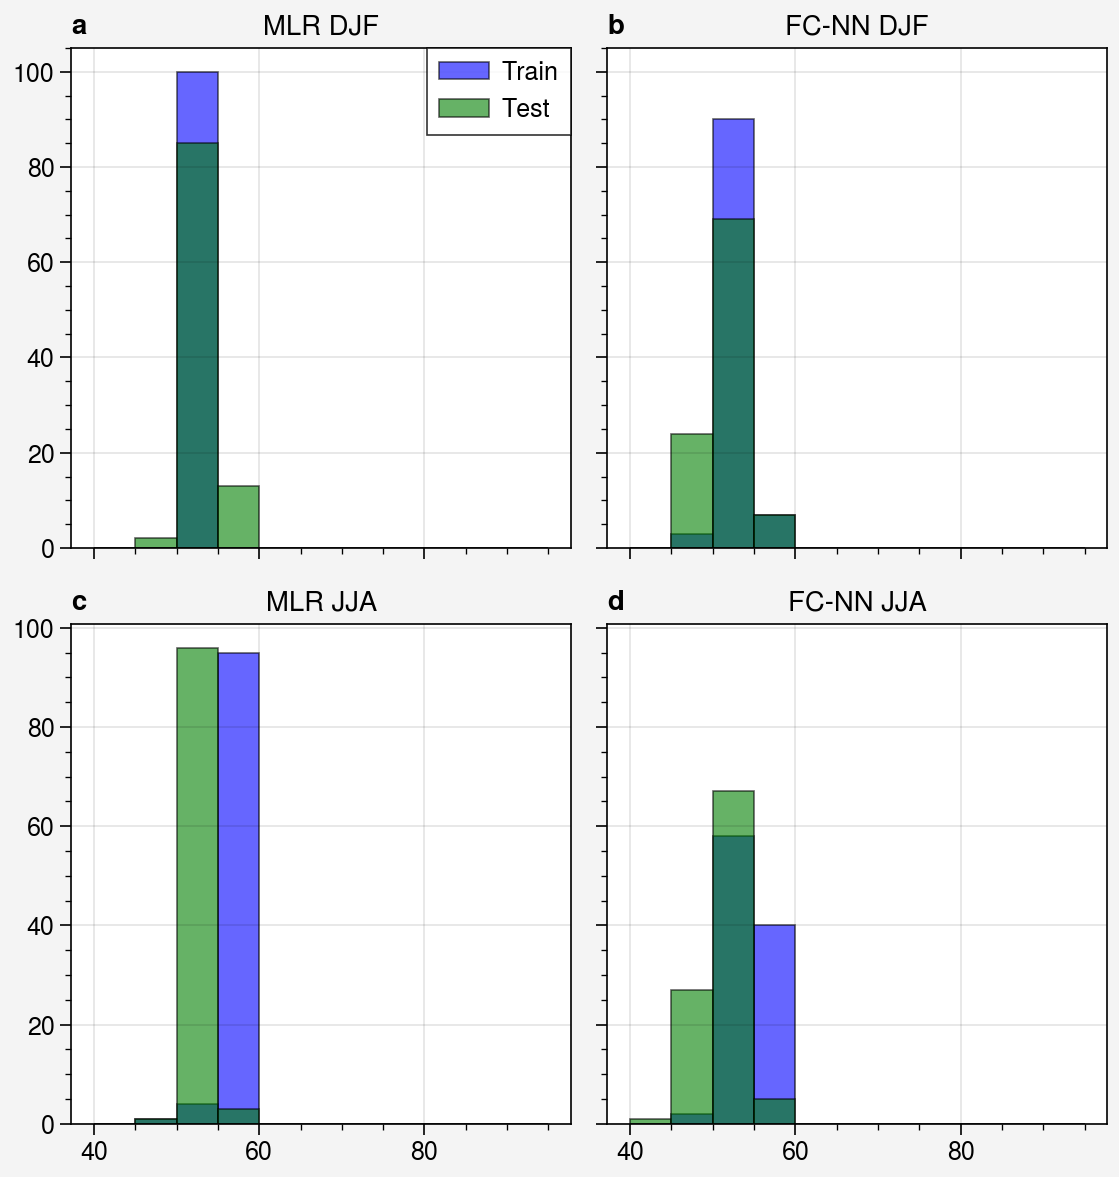

In [15]:
hist_bins=np.arange(40,100,5)
hist_multipanel(ds_model_indices,hist_bins,['MLR','FC-NN'],fname='')

### Figure 5: Reliability

In [16]:
# train=0,test=1
train_test=np.zeros((len(ds_model_indices['time'])))
train_test[2403::]=1
da_tt=xr.DataArray(train_test,coords={'time':ds_model_indices['time']},dims=['time']).to_dataset(name='tt')
ds_model_indices=xr.merge([da_tt,ds_model_indices])

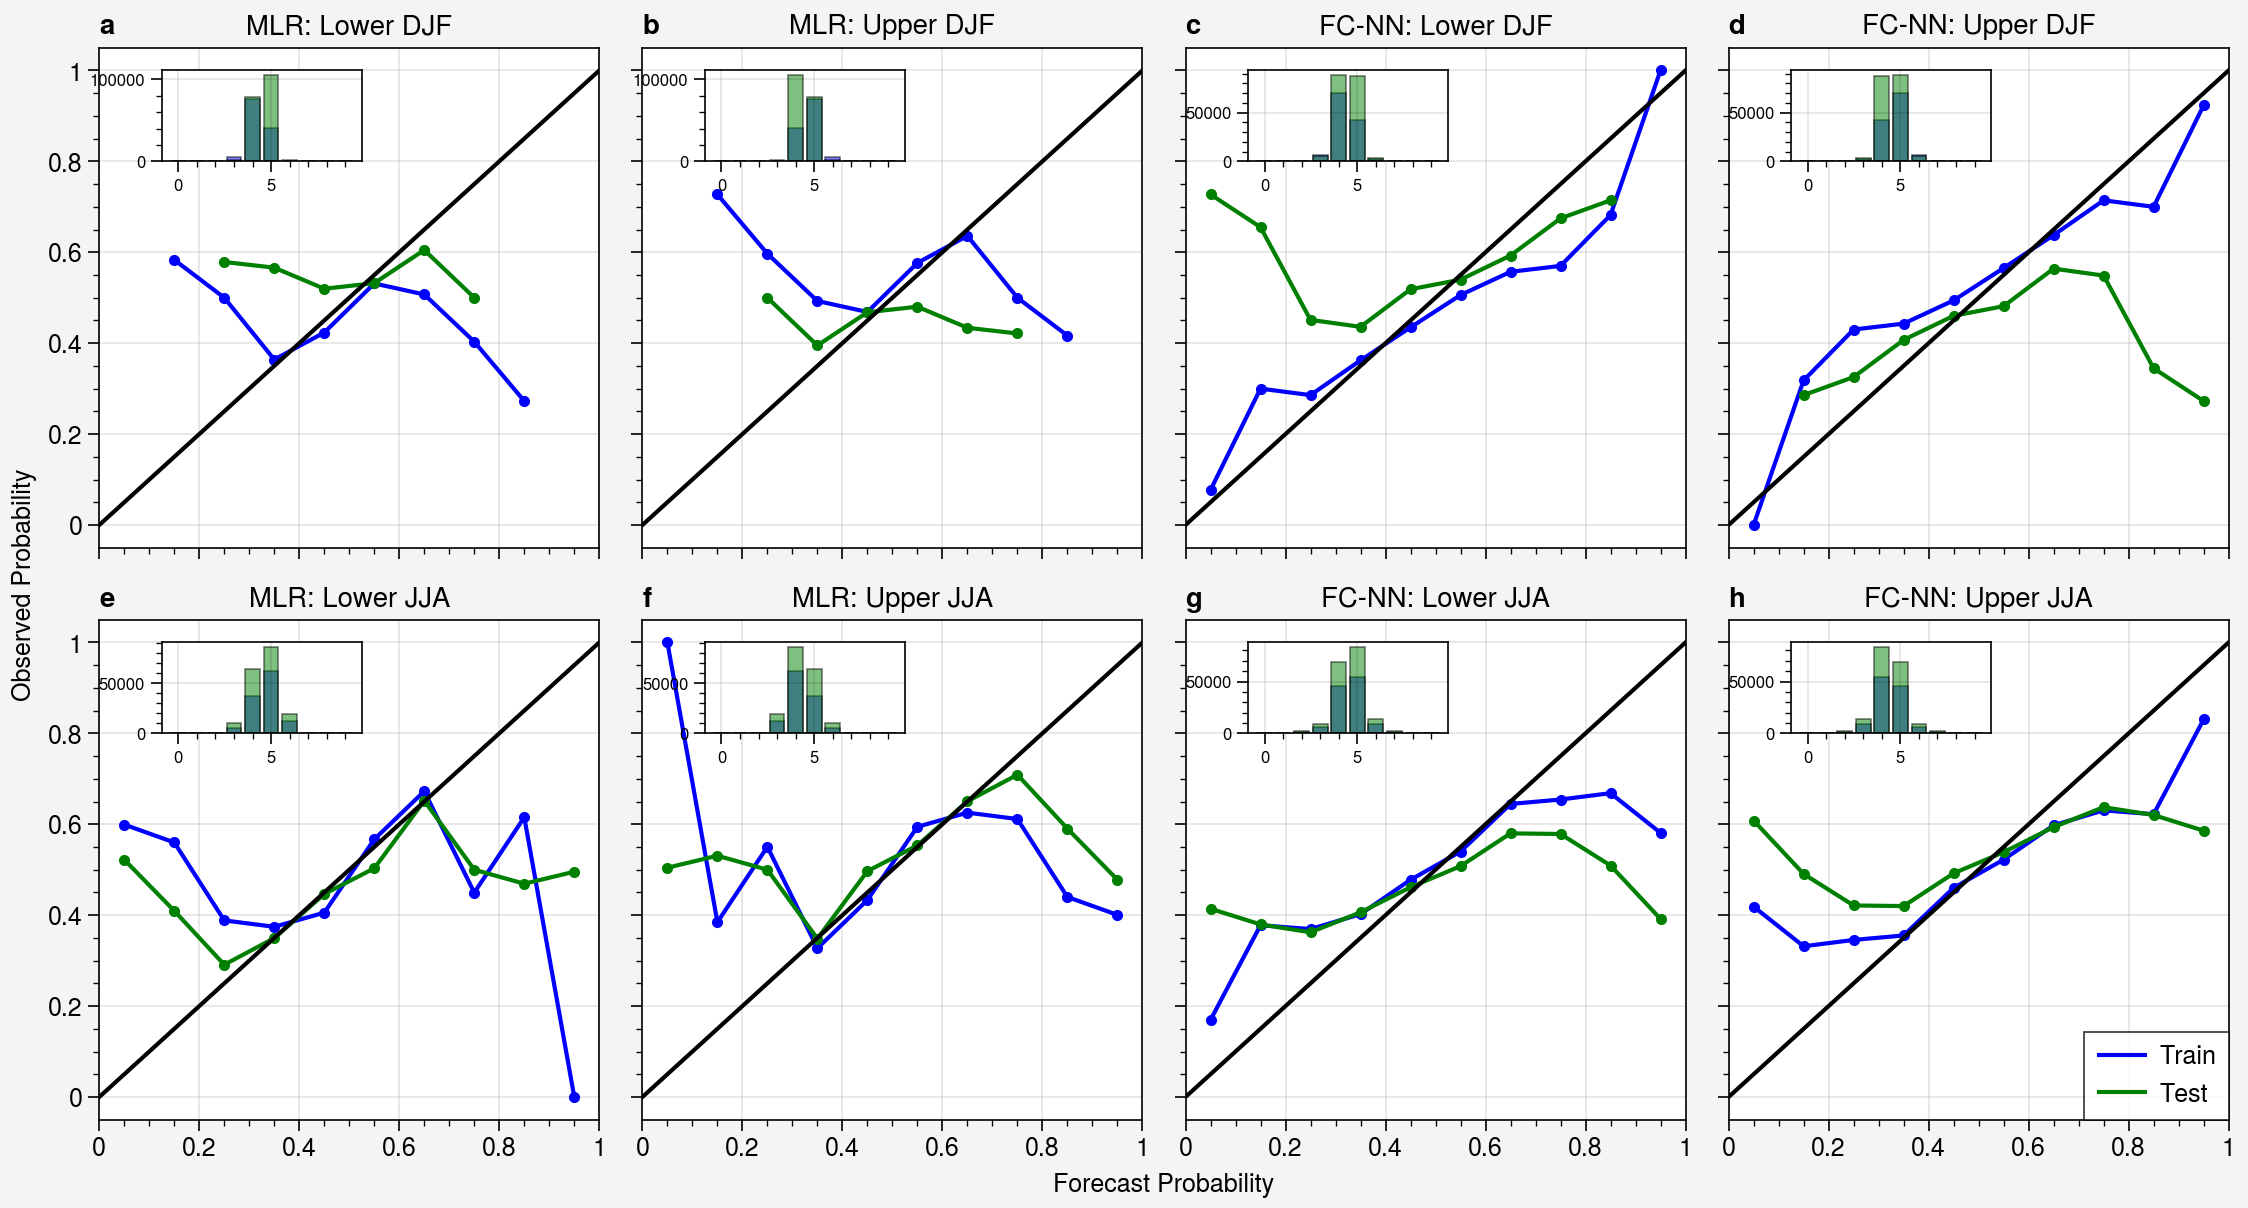

In [17]:
reliability_multi(ds_model_indices,['MLR','FC-NN'])


### Figure 6

In [18]:
fnames_fields='/scratch/kpegion/model_output.*.nc'
ds_model_fields=xr.open_mfdataset(fnames_fields,combine='nested',concat_dim='seas')
ds_model_fields['seas']=['DJF','JJA']
ds_model_fields['lrp']=ds_model_fields['lrp']/ds_model_fields['lrp'].std(['lat','lon','var'],skipna=True)


ds_mean=ds_model_fields['lrp'].mean(dim=['time','model'],skipna=True)
ds_max=ds_model_fields['lrp'].max(dim=['lat','lon','var'],skipna=True)
ds_model_fields['lrp']=xr.where(np.abs(ds_max)>1e-8,ds_model_fields['lrp']/ds_max,np.nan)
ds_model_fields

DJF cnn_cat 0 0
JJA cnn_cat 1 0


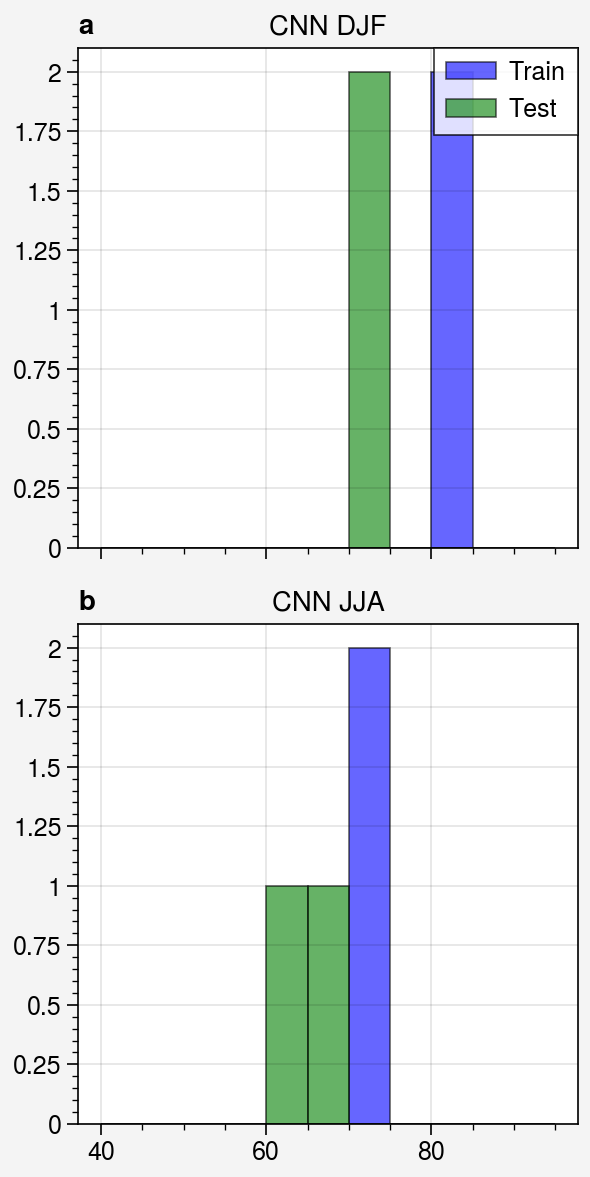

In [19]:
hist_bins=np.arange(40,100,5)
hist_multipanel(ds_model_fields,hist_bins,['CNN'],fname='')

### Figure 7

In [20]:
# train=0,test=1
train_test=np.zeros((len(ds_model_fields['time'])))
train_test[2870::]=1
da_tt=xr.DataArray(train_test,coords={'time':ds_model_fields['time']},dims=['time']).to_dataset(name='tt')
ds_model_fields=xr.merge([da_tt,ds_model_fields],compat='override')

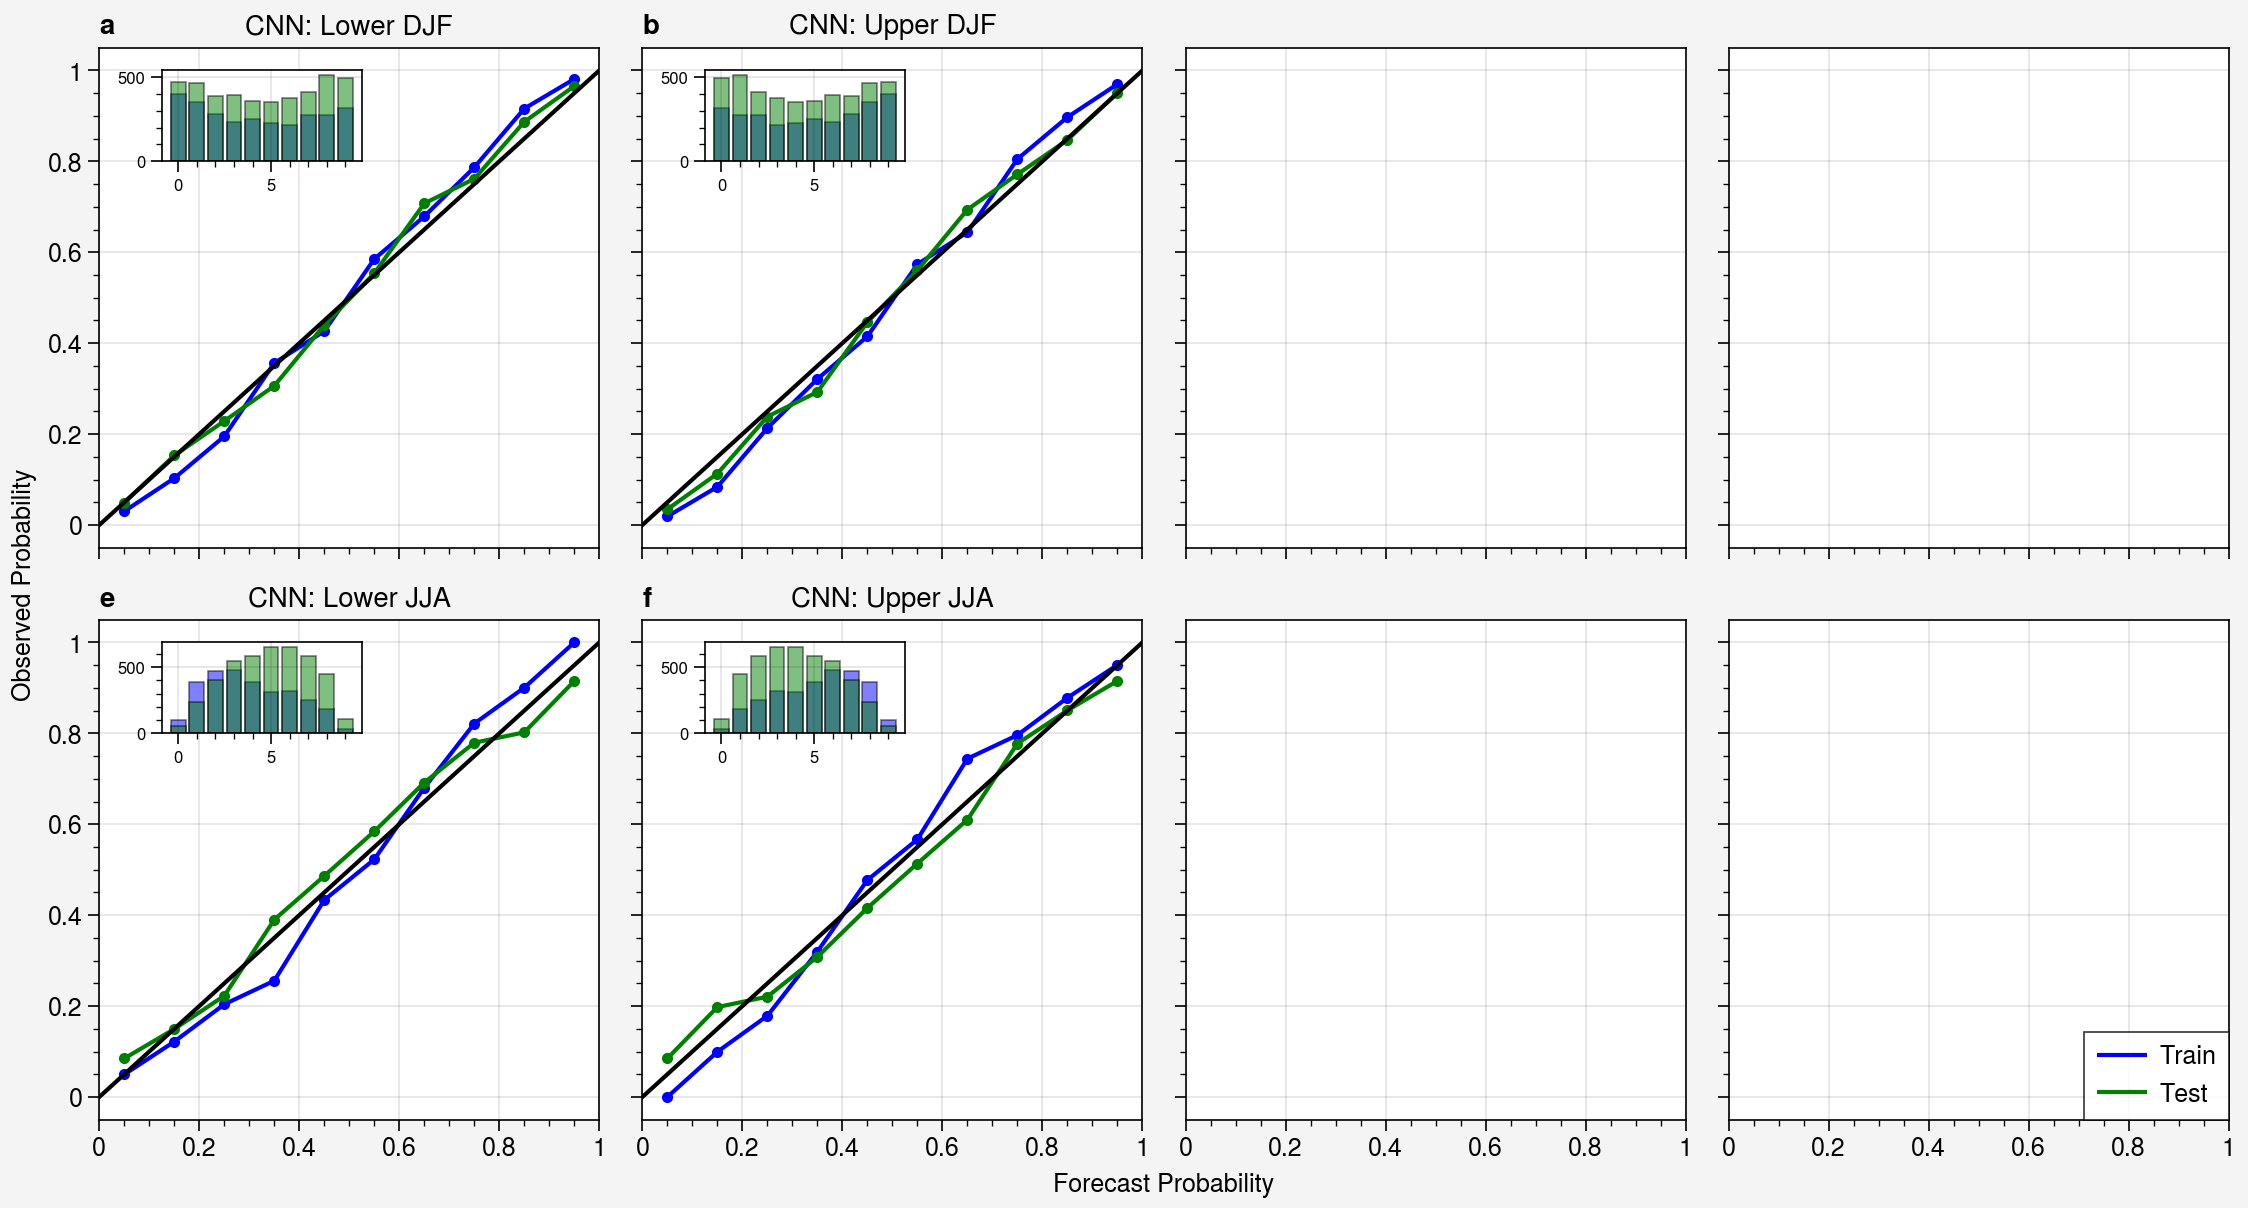

In [21]:
reliability_multi(ds_model_fields,['CNN'])

### Figure 8

TP:  2474  FP:  639  TN:  2914  FN:  1080


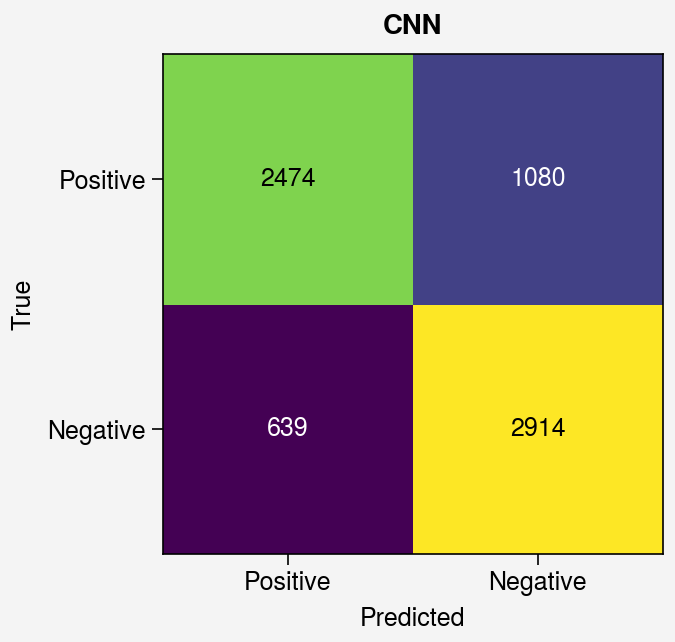

In [22]:
for i,t in zip(ds_model_fields['model_type'].values,['CNN']):
    make_cm(ds_model_fields,i,title=t)
    

### Settings for next few plots

In [23]:
confidence_thresh=0.8
r='lrp.alpha_1_beta_0'
#r='lrp.z'
mean_dims=['time','model']


### Figure 9: Confident True Positives

In [24]:
ds_anoms=getFields()
ds_comp=ds_anoms.where(np.logical_and(ds_model_fields['pred']==ds_model_fields['verif'],
                                      ds_model_fields['probs'].sel(cat='Upper')>=confidence_thresh)).sel(model_type='cnn_cat').mean(dim=['time','model'])
ds_comp.compute()

fcsts=ds_model_fields.where(np.logical_and(ds_model_fields['pred']==ds_model_fields['verif'],
                                           ds_model_fields['probs'].sel(cat='Upper')>=confidence_thresh)).sel(model_type='cnn_cat')

ds_tmp=fcsts['lrp'].sel(rules=r).mean(dim=mean_dims,skipna=True).compute()


plotCompLRPCirc(ds_tmp,ds_comp,file='')
plotCompLRPGlobe(ds_tmp,ds_comp,file='')

In [25]:
ds_ts_pos=getTS(ds_anoms,ds_comp,'JJA',file='')

for seas in ds_ts['seas'].values:
    
    f, axs = pplt.subplots(nrows=4,ncols=2)
    ds_seas=ds_ts.sel(seas=seas)/ds_ts.sel(seas=seas).std(dim='time')

    for ax,v in zip(axs,list(ds_ts.keys())):
        ax.plot(ds_seas['time'],ds_seas[v])
        ax.format(title=v)
    f.format(suptitle=seas,ylabel='std')

### Figure 10: Confident True Negatives

In [26]:
ds_comp=ds_anoms.where(np.logical_and(ds_model_fields['pred']==ds_model_fields['verif'],
                                      ds_model_fields['probs'].sel(cat='Lower')>=confidence_thresh)).sel(model_type='cnn_cat').mean(dim=['time','model'])
ds_comp.compute()

fcsts=ds_model_fields.where(np.logical_and(ds_model_fields['pred']==ds_model_fields['verif'],
                                           ds_model_fields['probs'].sel(cat='Lower')>=confidence_thresh)).sel(model_type='cnn_cat')

ds_tmp=fcsts['lrp'].sel(rules=r).mean(dim=mean_dims,skipna=True).compute()

In [27]:
ds_ts_neg=getTS(ds_anoms,ds_comp,'JJA',file='')

In [28]:
ds_ts_neg

<xarray.Dataset>
Dimensions:  (time: 14610)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
Data variables:
    sst      (time) float32 -6.762 -6.586 -6.731 -6.796 ... 7.532 8.181 8.618
    z500     (time) float32 8.665e+07 1.036e+08 1.479e+08 ... 0.0 0.0 0.0
    z850     (time) float32 6.093e+07 3.924e+07 6.332e+07 ... 0.0 0.0 0.0
    olr      (time) float32 3.635e+03 4.225e+03 5.441e+03 ... 0.0 0.0 0.0
    u200     (time) float32 1.056e+04 5.865e+03 6.275e+03 ... 0.0 0.0 0.0
    u850     (time) float32 1.947e+03 -147.6 827.9 265.8 ... 0.0 0.0 0.0 0.0
    v200     (time) float32 3.861e+03 1.385e+03 1.556e+03 ... 0.0 0.0 0.0
    v850     (time) float32 1.279e+03 1.617e+03 1.643e+03 ... 0.0 0.0 0.0

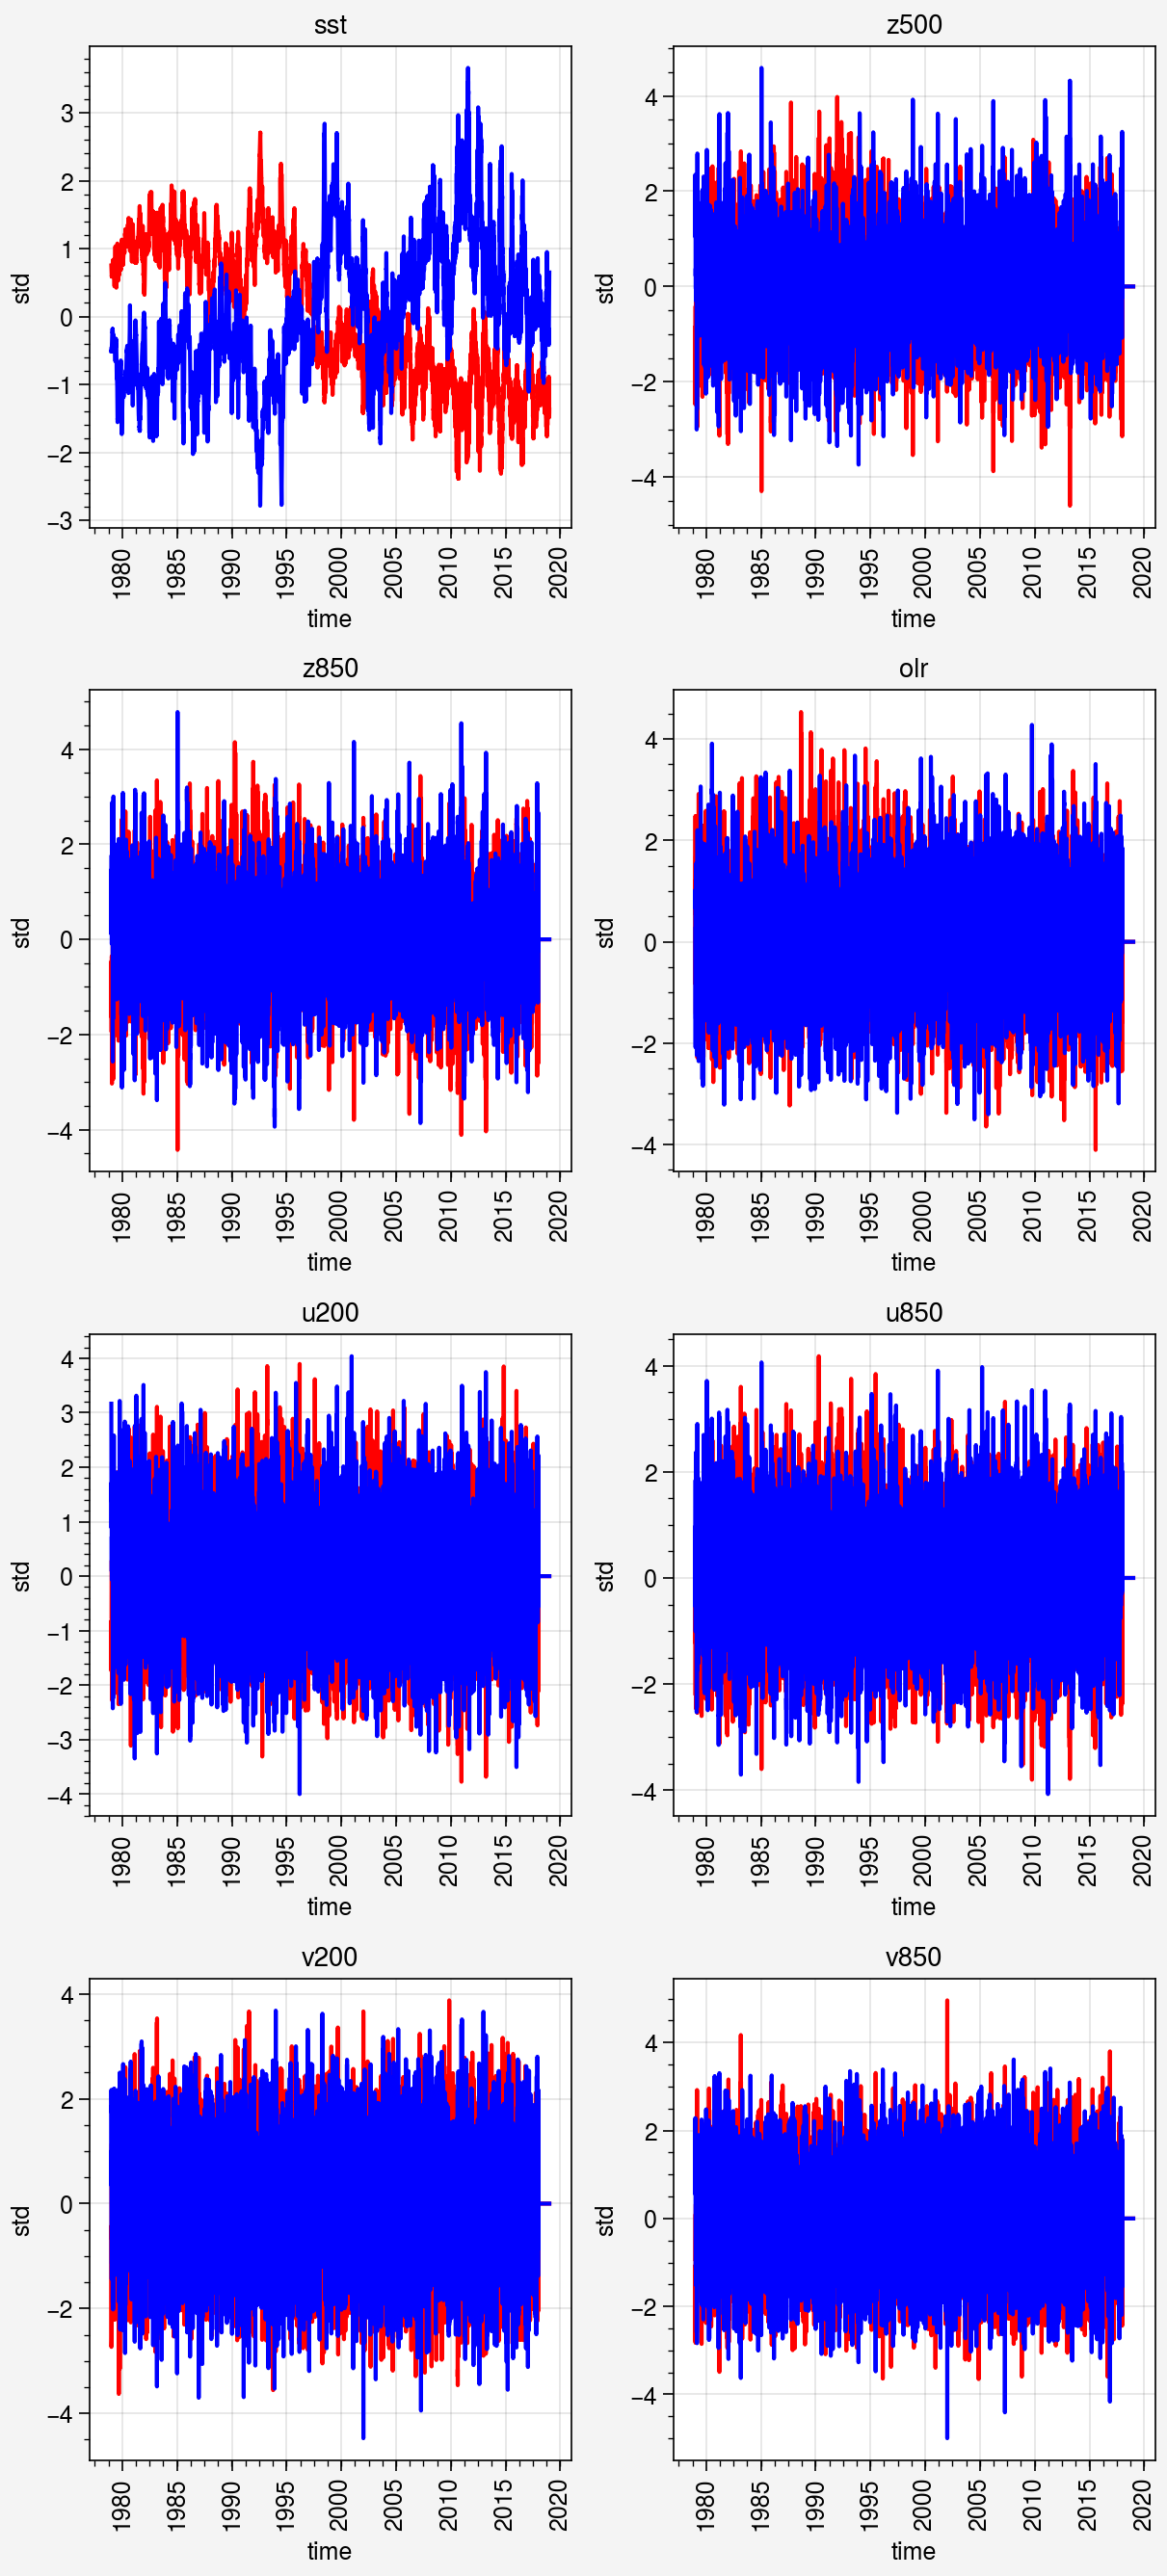

In [29]:
f, axs = pplt.subplots(nrows=4,ncols=2,share=False)
ds_pos=(ds_ts_pos-ds_ts_pos.mean())/ds_ts_pos.std(dim='time',skipna=True)
ds_neg=(ds_ts_neg-ds_ts_neg.mean())/ds_ts_neg.std(dim='time',skipna=True)

for ax,v in zip(axs,list(ds_ts_pos.keys())):
    ax.plot(ds_ts_pos['time'],ds_pos[v],color='r')
    ax.plot(ds_ts_neg['time'],ds_neg[v],'b')
    ax.format(title=v)
f.format(ylabel='std')


In [30]:
N=14610
ds_Pneg=powerSpectra(ds_neg,N)
ds_Ppos=powerSpectra(ds_pos,N)

N2=int(N/2+1)
h=np.arange(0,N2)
r_list_neg=rednoise(ds_neg,h)
r_list_pos=rednoise(ds_pos,h)

sst 0.9968627597867525
z500 0.8910120035626053
z850 0.8748760892838512
olr 0.8171775149258156
u200 0.8391030902189813
u850 0.8166880161455626
v200 0.7334285284762969
v850 0.7138030789626302
sst 0.9983097070227129
z500 0.9008411081243981
z850 0.8771578537377751
olr 0.7917011915103879
u200 0.8522076243207113
u850 0.8196593029041137
v200 0.7595550393615684
v850 0.7418071515876326


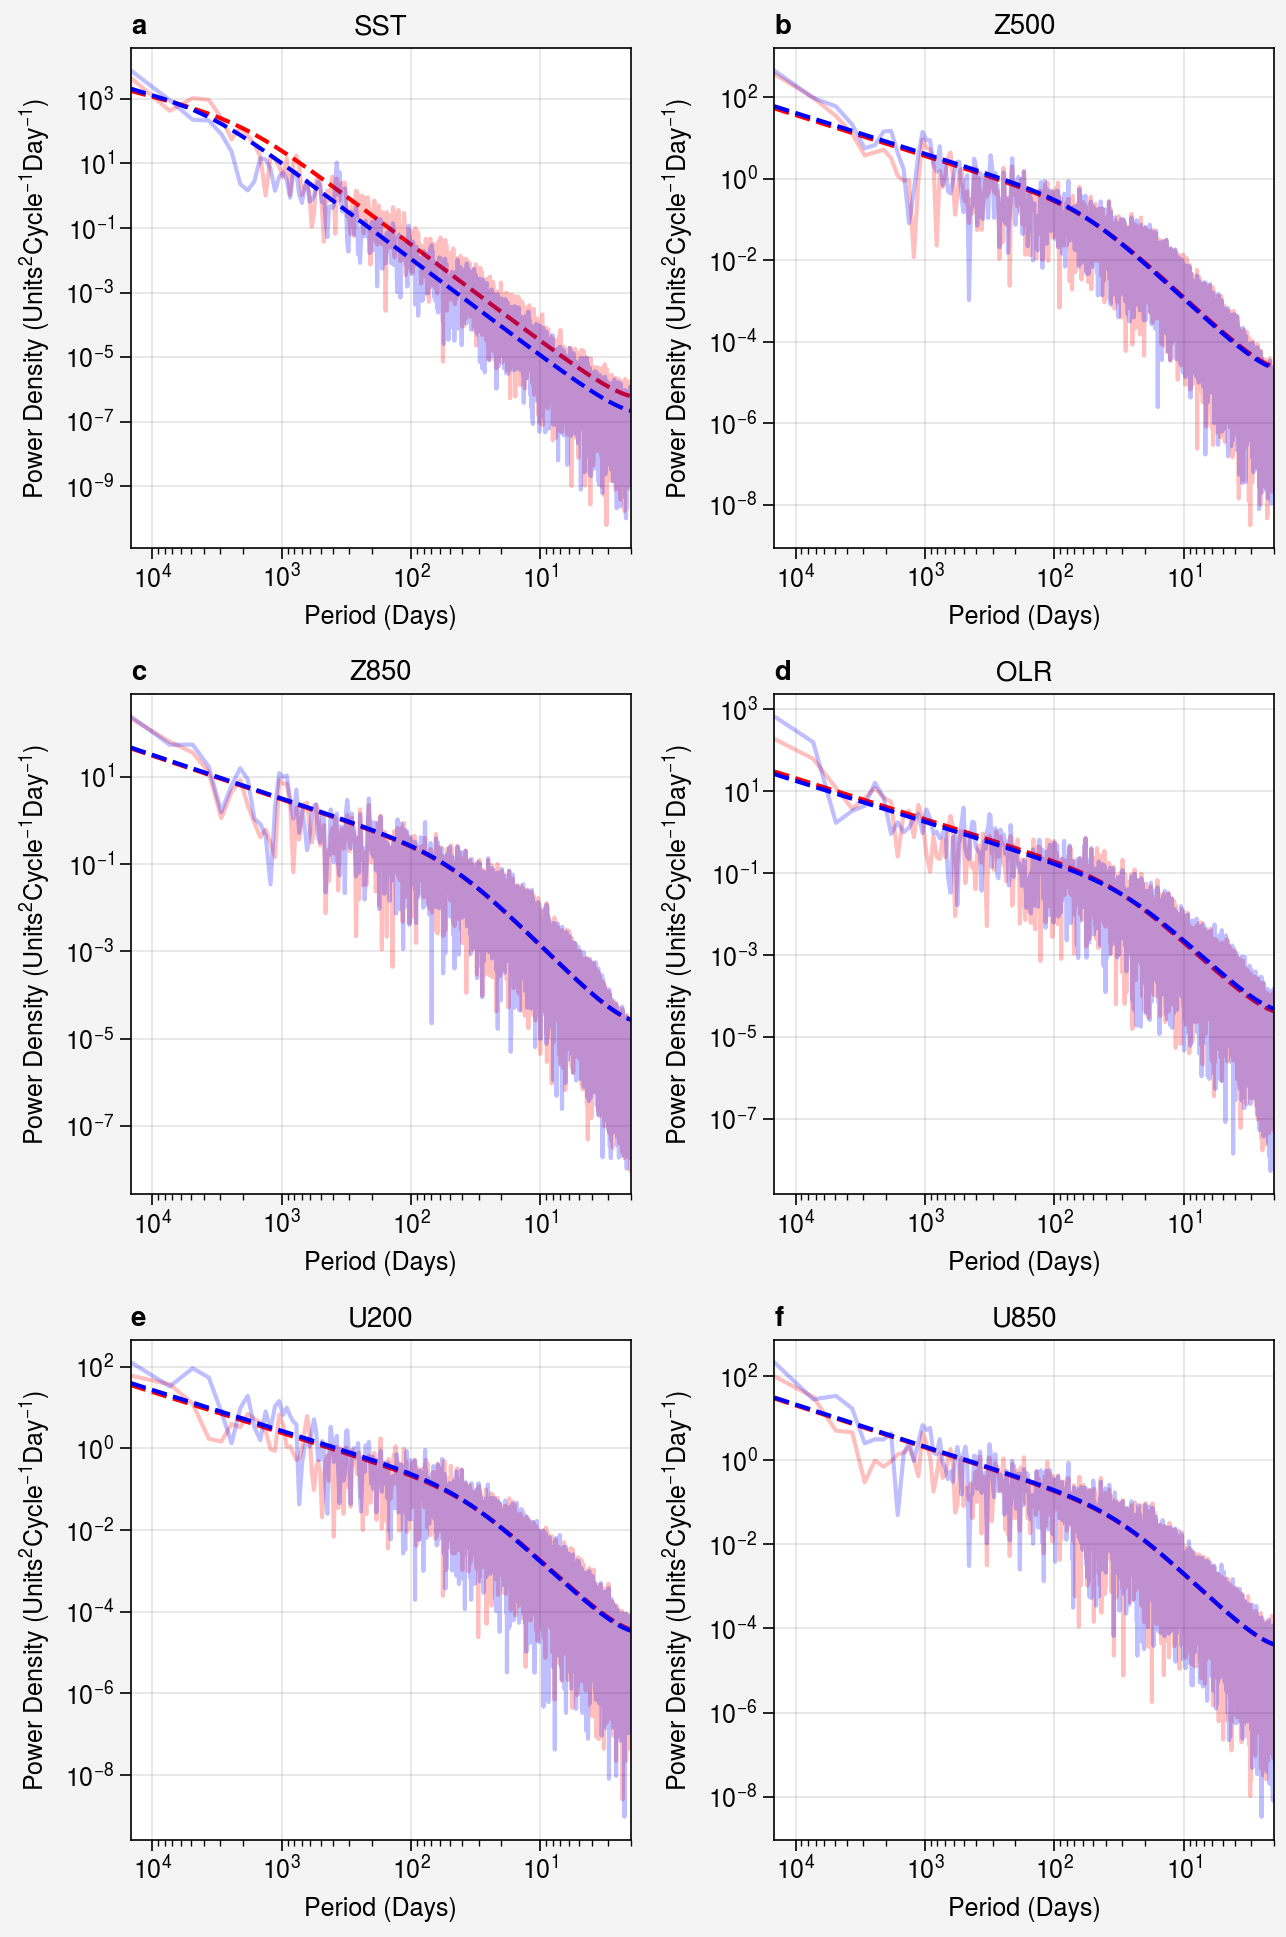

In [31]:
f, axs = pplt.subplots(nrows=3,ncols=2,share=False)
for i,(ax,v) in enumerate(zip(axs,list(ds_Pneg.keys()))):
    
    var_scale=np.sum(ds_Pneg[v].values)/np.sum(r_list_neg[i])
    ax.plot(1/ds_Pneg['freq'][1::],ds_Pneg[v][1::]/ds_Pneg['freq'][1::],
            color='r',alpha=0.25)
    ax.plot(1/ds_Pneg['freq'][1::],r_list_neg[i][1::]*var_scale/ds_Pneg['freq'][1::],
            color='r',linestyle='--')

    var_scale=np.sum(ds_Ppos[v].values)/np.sum(r_list_pos[i])
    ax.plot(1/ds_Ppos['freq'][1::],ds_Ppos[v][1::]/ds_Ppos['freq'][1::],
            color='b',alpha=0.25)
    ax.plot(1/ds_Ppos['freq'][1::],r_list_pos[i][1::]*var_scale/ds_Ppos['freq'][1::],
            color='b',linestyle='--')
    
    ax.format(title=v.upper(),xlabel='Period (Days)',
              yscale='log',yformatter='log',xscale='log',xformatter='log',abc=True)

f.format(ylabel='Power Density (Units$^{2}$Cycle$^{-1}$Day$^{-1}$)')

plotCompLRPCirc(ds_tmp,ds_comp,file='')
plotCompLRPGlobe(ds_tmp,ds_comp,file='')
